# Get Kaggle dataset

Upload kaggle.json

In [ ]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artemkramov","key":"e23e079bd58bf2b260208ca8c5d2d64c"}'}

Copy the JSON file, set permissions, show the list of Kaggle datasets to ensure that the `kaggle` command is working

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Download the dataset and unzip it

In [ ]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [21:10<00:00, 26.1MB/s]
100% 28.6G/28.6G [21:10<00:00, 24.2MB/s]


In [ ]:
!unzip airbus-ship-detection.zip -d "/content"

In [ ]:
!rm airbus-ship-detection.zip

In [ ]:
import os

print("Number of files in the training folder: {}".format(len(os.listdir("train_v2"))))

Number of files in the training folder: 192556


# Install depemdencies and import them

In [ ]:
!pip install accelerate -U
!pip install -q mediapy
!pip install albumentations
!pip install datasets
!pip install transformers
!pip install wandb
!pip install -q evaluate

In [ ]:
from os.path import join
import mediapy as media
import os
import tqdm
import pandas as pd
import numpy as np
import albumentations as A
from datasets import Dataset, IterableDataset, load_metric
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader
import evaluate
import wandb

# Set global variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content"
TRAINING_DIR = join(BASE_DIR, "train_v2")
TRAINING_DATASET = join(BASE_DIR, "train_ship_segmentations_v2.csv")
MODEL_PATH = "/content/drive/MyDrive/Airbus/checkpoints_classifier"
WIDTH = 768
HEIGHT = 768
NUM_CHANNELS = 3

In [ ]:
# Add these lines to ensure that truncated images can be loaded (such images are presented in the dataset)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Prepare dataset for training

In [ ]:
df = pd.read_csv(TRAINING_DATASET)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
print("Number of records within the dataset: {}".format(df.shape[0]))
print("Number of unique images within the dataset: {}".format(df['ImageId'].unique().shape[0]))

Number of records within the dataset: 231723
Number of unique images within the dataset: 192556


In [ ]:
df = shuffle(df)
df_train, df_validation = train_test_split(df, test_size=0.2)
df_validation = df_validation.head(5000)
print(df_train.shape, df_validation.shape)

(185378, 2) (5000, 2)


In [ ]:
def generator_fn(df_subset):

  # Define a number of images with/without ships
  num_empty_records = df_subset[df_subset['EncodedPixels'].isna()].shape[0]
  num_images_with_ships = df_subset[df_subset['EncodedPixels'].notna()]['ImageId'].value_counts().shape[0]
  total_number_of_images = num_empty_records + num_images_with_ships

  transformations = [
      A.HorizontalFlip(p=1),
      A.VerticalFlip(p=1),
      A.RandomRotate90(p=1),
      A.Transpose(p=1)
  ]

  current_number_of_samples_with_ships = 0
  current_number_of_samples_with_ships_wo_aug = 0
  for _, row in df_subset.iterrows():
    try:
      filename = join(TRAINING_DIR, row['ImageId'])
      image = media.read_image(filename)
      label = 0
      if not pd.isna(row['EncodedPixels']):
        label = 1
      yield {
          'image': image,
          'labels': label
      }
      if label:
        current_number_of_samples_with_ships += 1
        current_number_of_samples_with_ships_wo_aug += 1
        for aug in transformations:
          if num_images_with_ships - current_number_of_samples_with_ships_wo_aug >= num_empty_records - current_number_of_samples_with_ships:
            break

          augmented = aug(image=image)
          current_number_of_samples_with_ships += 1
          yield {
            'image': augmented['image'],
            'labels': label
          }
    except FileNotFoundError:
      pass



In [ ]:
dataset_train = IterableDataset.from_generator(generator_fn, gen_kwargs={'df_subset': df_train})
dataset_validation = IterableDataset.from_generator(generator_fn, gen_kwargs={'df_subset': df_validation})

""

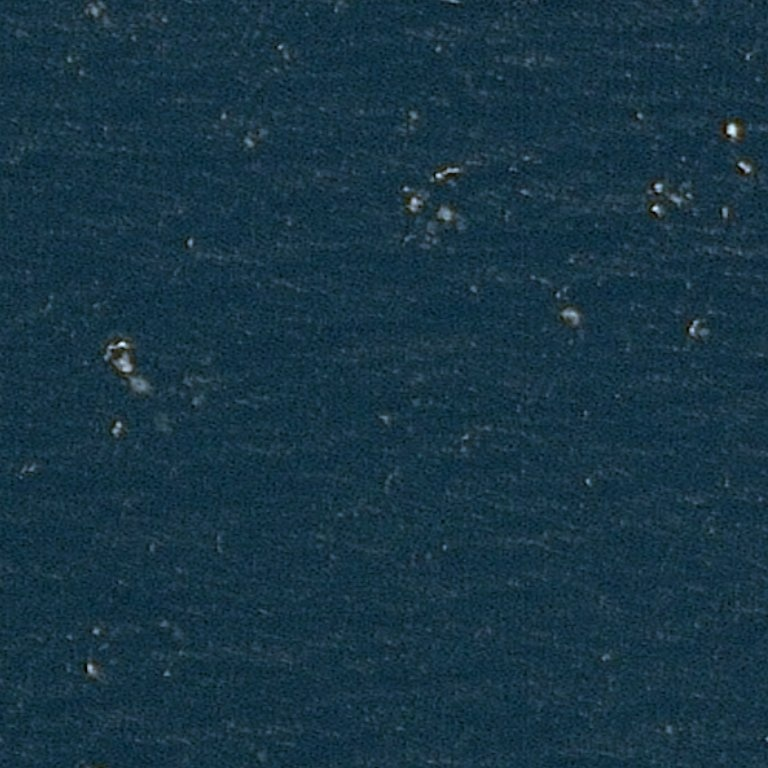

In [ ]:
for sample in dataset_train:
  media.show_image(sample['image'])
  break

In [ ]:
id2label = {0: 'no-ship', 1: 'ship'}

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [ ]:
def collate_fn(batch):
  images = processor([x['image'] for x in batch], return_tensors='pt')
  return {
      'pixel_values': images['pixel_values'],
      'labels': torch.tensor([x['labels'] for x in batch])
  }

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [ ]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-15-a00513a56fba>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
labels = list(id2label.values())

In [ ]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Get a current GPU device and attach the model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
training_args = TrainingArguments(
  output_dir=MODEL_PATH,
  per_device_train_batch_size=128,
  per_device_eval_batch_size=128,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  max_steps=700
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset_train,
    eval_dataset=dataset_validation,
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.124100,0.171060,0.943824
200,0.086500,0.098084,0.966475
300,0.069200,0.107142,0.963455
400,0.053600,0.117344,0.959529
500,0.039500,0.104427,0.968892
600,0.047200,0.080869,0.972365
700,0.036000,0.078411,0.972365


***** train metrics *****
  epoch                    =          1.0
  total_flos               = 6466435519GF
  train_loss               =        0.069
  train_runtime            =   0:37:46.12
  train_samples_per_second =       39.539
  train_steps_per_second   =        0.309
